# BAC integrals along or cross-shelf



In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import matplotlib.cm as cm

import matplotlib as mpl

from matplotlib import gridspec

from math import *

from mpl_toolkits.mplot3d.axes3d import Axes3D

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns

import canyon_tools.readout_tools as rout

import canyon_tools.savitzky_golay as sg

In [2]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [3]:
#Base case, iso =1 , No 3d diff.
#CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

NoCCanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
NoCCanyonGridOut = Dataset(NoCCanyonGrid)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

Ptracer='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
PtracerOut = Dataset(Ptracer)
Ptracer07='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc'
PtracerOut07 = Dataset(Ptracer07)

Ptracer12='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run12/ptracersGlob.nc'
PtracerOut12 = Dataset(Ptracer12)
Ptracer25='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run25/ptracersGlob.nc'
PtracerOut25 = Dataset(Ptracer25)

Ptracer11='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run11/ptracersGlob.nc'
PtracerOut11 = Dataset(Ptracer11)
Ptracer24='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run24/ptracersGlob.nc'
PtracerOut24 = Dataset(Ptracer24)

Ptracer3D04='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04/ptracersGlob.nc'
PtracerOut3D04 = Dataset(Ptracer3D04)
Ptracer30='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run30/ptracersGlob.nc'
PtracerOut30 = Dataset(Ptracer30)

Ptracer3D07='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run07/ptracersGlob.nc'
PtracerOut3D07 = Dataset(Ptracer3D07)
Ptracer3D06='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06/ptracersGlob.nc'
PtracerOut3D06 = Dataset(Ptracer3D06)

Ptracer15='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run15/ptracersGlob.nc'
PtracerOut15 = Dataset(Ptracer15)
Ptracer27='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run27/ptracersGlob.nc'
PtracerOut27 = Dataset(Ptracer27)

Ptracer14='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run14/ptracersGlob.nc'
PtracerOut14 = Dataset(Ptracer14)
Ptracer26='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run26/ptracersGlob.nc'
PtracerOut26 = Dataset(Ptracer26)

Ptracer19='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run19/ptracersGlob.nc'
PtracerOut19 = Dataset(Ptracer19)
Ptracer23='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run23/ptracersGlob.nc'
PtracerOut23 = Dataset(Ptracer23)

PtracerBar='/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'
PtracerOutBar = Dataset(PtracerBar)
PtracerBarFlat='/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'
PtracerOutBarFlat = Dataset(PtracerBarFlat)



In [4]:
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
bathyNoC = rout.getField(NoCCanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacCNoC = rout.getField(NoCCanyonGrid, 'HFacC')
MaskCNoC = rout.getMask(NoCCanyonGrid, 'HFacC')
rANoC = rout.getField(NoCCanyonGrid, 'rA')
rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']

time = CanyonStateOut.variables['T']

In [5]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                ConcArea[tt,i,j] = TrBottom*ra[i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
                
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    

    #ConcAreaMasked = np.ma.masked_values(ConcDepths,-2.5)
    #ConcDepths[np.where(np.ma.getmask(ConcDepthsMasked)==True)] = np.nan

    return (ConcArea,
            np.ma.masked_array(Conc, mask=maskShelf),
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def get_ConcArea(exp, hFacC, rA, bathy,tracer='Tr1'):
    '''exp: netcdf dataset of tracer file
       tracer: string with tracer name (default is 'Tr01)
       
       RETURNS: ConcFilt'''
    
    Tr = rout.getField(exp,tracer) 
    ConcArea1, Conc1, ConcFilt1, Area1 = ConcArea(Tr, hFacC, rA, bathy)
    return(ConcFilt1)


In [ ]:
#expsCanyon = [Ptracer,Ptracer11,Ptracer12,Ptracer3D04,Ptracer3D05,Ptracer3D06,Ptracer15,Ptracer14,Ptracer19]
#expsFlat = [Ptracer07,Ptracer24,Ptracer25,Ptracer30,Ptracer30,Ptracer07,Ptracer27,Ptracer26,Ptracer23]

#labels = ['Base',
#          '$Kv=10^{-4}m^2s^{-1}$',
#          '$Kv=10^{-3}m^2s^{-1}$',
#          '$Kv_{can}=10^{-3},Kv_{out}=10^{-7}m^2s^{-1}$',
#          '$Kv_{can}=10^{-4},Kv_{out}=10^{-5}m^2s^{-1}$',
#          '$Kv_{can}=10^{-3},Kv_{out}=10^{-5}m^2s^{-1}$',
#          'Higher N',
#          'Lower N',
#          'Lower f']

#tracers = ['Tr1','Tr2','Tr3','Tr1','Tr1','Tr1','Tr1','Tr1','Tr1','Tr1']
#tracersNoC = ['Tr1','Tr1','Tr1','Tr1','Tr1','Tr1','Tr1','Tr1','Tr1','Tr1']


In [14]:
def plot_pool_profile_AS(tt,colors,tracers,tracersNoC,labels,expsCanyon,expsFlat):
    
    sns.set_palette(colors)
    sns.set_context('talk',font_scale=1.3)
    
    
    fig = plt.figure(figsize=(10,14))
    ax1= plt.subplot(2,1,1,frameon = True)
    ax2= plt.subplot(2,1,2,frameon = True)


    y_vect = yc[227:300,100]/1000.0
    x_vect = xc[227,100:]/1000.0


    for exp,expFlat,tracer,tracerFlat,lab in zip(expsCanyon,expsFlat, tracers,tracersNoC, labels):

        BAC = get_ConcArea(exp, hFacC, rA, bathy,tracer=tracer) 
        BAC_flat = get_ConcArea(expFlat, hFacCNoC, rANoC, bathyNoC,tracer=tracerFlat) 

        data = BAC[tt,227:300,100:]
        data_effect = BAC[tt,227:300,100:]-BAC_flat[tt,227:300,100:]
        ax1.plot(x_vect,mean_AS_pool(data),'-', label=lab)
        ax1.legend(loc=0)
        ax2.plot(x_vect,mean_AS_pool(data_effect),'-', label=lab)
        ax2.legend(loc=0)


    ax1.set_xlabel('Alongshore distance [km]')    
    ax1.set_ylabel('Mean bottom average concentration [$(Mol/l)m^{-1}$]') 
    ax1.set_title('Canyon case, day %1.1f' %(tt/2.0))
    ax2.set_xlabel('Alongshore distance [km]')    
    ax2.set_ylabel('Mean bottom average concentration [$(Mol/l)m^{-1}$]') 
    ax2.set_title('Canyon effect, day %1.1f' %(tt/2.0))
    return (fig,ax1,ax2)

In [15]:
def plot_pool_profile_AS_BAR(tt,colors,tracers,tracersNoC,labels):
    
    sns.set_palette(colors)
    sns.set_context('talk',font_scale=1.3)
    
    
    fig = plt.figure(figsize=(10,14))
    ax1= plt.subplot(2,1,1,frameon = True)
    ax2= plt.subplot(2,1,2,frameon = True)


    y_vect = yc[227:300,100]/1000.0
    x_vect = xc[227,100:]/1000.0


    for tracer,tracerFlat,lab in zip(tracers,tracersNoC, labels):

        BAC = get_ConcArea(PtracerBar, hFacC, rA, bathy,tracer=tracer) 
        BAC_flat = get_ConcArea(PtracerBarFlat, hFacCNoC, rANoC, bathyNoC,tracer=tracerFlat) 

        data = BAC[tt,227:300,100:]
        data_effect = BAC[tt,227:300,100:]-BAC_flat[tt,227:300,100:]
        ax1.plot(x_vect,mean_AS_pool(data),'-', label=lab)
        ax1.legend(loc=0)
        ax2.plot(x_vect,mean_AS_pool(data_effect),'-', label=lab)
        ax2.legend(loc=0)


    ax1.set_xlabel('Alongshore distance [km]')    
    ax1.set_ylabel('Mean bottom average concentration [$(Mol/l)m^{-1}$]') 
    ax1.set_title('Canyon case, day %1.1f' %(tt/2.0))
    ax2.set_xlabel('Alongshore distance [km]')    
    ax2.set_ylabel('Mean bottom average concentration [$(Mol/l)m^{-1}$]') 
    ax2.set_title('Canyon effect, day %1.1f' %(tt/2.0))
    return (fig,ax1,ax2)

In [16]:
def plot_pool_profile_CS(tt,colors,tracers,tracersNoC,labels,expsCanyon,expsFlat):
    
    sns.set_palette(colors)
    sns.set_context('talk',font_scale=1.3)
    
    
    fig = plt.figure(figsize=(10,14))
    ax1= plt.subplot(2,1,1,frameon = True)
    ax2= plt.subplot(2,1,2,frameon = True)


    y_vect = yc[227:300,100]/1000.0
    x_vect = xc[227,100:]/1000.0

    for exp,expFlat,tracer,tracerFlat,lab in zip(expsCanyon,expsFlat, tracers,tracersNoC, labels):

        BAC = get_ConcArea(exp, hFacC, rA, bathy,tracer=tracer) 
        BAC_flat = get_ConcArea(expFlat, hFacCNoC, rANoC, bathyNoC,tracer=tracerFlat) 

        data = BAC[tt,227:300,100:]
        data_effect = BAC[tt,227:300,100:]-BAC_flat[tt,227:300,100:]
        ax1.plot(y_vect,mean_CS_pool(data),'-', label=lab)
        ax1.legend(loc=0)
        ax2.plot(y_vect,mean_CS_pool(data_effect),'-', label=lab)
        ax2.legend(loc=0)


    ax1.set_xlabel('Cross-shore distance [km]')    
    ax1.set_ylabel('Mean bottom average concentration [$(Mol/l)m^{-1}$]') 
    ax1.set_title('Canyon case, day %1.1f' %(tt/2.0))
    ax2.set_xlabel('Cross-shore distance [km]')    
    ax2.set_ylabel('Mean bottom average concentration [$(Mol/l)m^{-1}$]') 
    ax2.set_title('Canyon effect, day %1.1f' %(tt/2.0))
    return (fig,ax1,ax2)

In [21]:
def plot_pool_profile_CS_BAR(tt,colors,tracers,tracersNoC,labels):
    
    sns.set_palette(colors)
    sns.set_context('talk',font_scale=1.3)
    
    
    fig = plt.figure(figsize=(10,14))
    ax1= plt.subplot(2,1,1,frameon = True)
    ax2= plt.subplot(2,1,2,frameon = True)


    y_vect = yc[227:300,100]/1000.0
    x_vect = xc[227,100:]/1000.0

    for tracer,tracerFlat,lab in zip(tracers,tracersNoC, labels):

        BAC = get_ConcArea(PtracerBar, hFacC, rA, bathy,tracer=tracer) 
        BAC_flat = get_ConcArea(PtracerBarFlat, hFacCNoC, rANoC, bathyNoC,tracer=tracerFlat) 

        data = BAC[tt,227:300,100:]
        data_effect = BAC[tt,227:300,100:]-BAC_flat[tt,227:300,100:]
        ax1.plot(y_vect,mean_CS_pool(data),'-', label=lab)
        ax1.legend(loc=0)
        ax2.plot(y_vect,mean_CS_pool(data_effect),'-', label=lab)
        ax2.legend(loc=0)


    ax1.set_xlabel('Cross-shore distance [km]')    
    ax1.set_ylabel('Mean bottom average concentration [$(Mol/l)m^{-1}$]') 
    ax1.set_title('Canyon case, day %1.1f' %(tt/2.0))
    ax2.set_xlabel('Cross-shore distance [km]')    
    ax2.set_ylabel('Mean bottom average concentration [$(Mol/l)m^{-1}$]') 
    ax2.set_title('Canyon effect, day %1.1f' %(tt/2.0))
    return (fig,ax1,ax2)

In [10]:
def mean_AS_pool(data):
    '''
    INPUT:
    data: 3d slice of output (np. array with t,y,x dimensions)
    tt: time index
     
    RETURNS: AS_mean (alongshore mean of BAC)
    
    '''
    return(np.nanmean(data,axis=0))
   
  
    
def mean_CS_pool(data):
    '''
    INPUT:
    data: 3d slice of output (np. array with t,y,x dimensions)
    RETURNS: CS_mean (cross-shore mean of BAC)
    
    '''
    return(np.nanmean(data,axis=1))
  

(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(<matplotlib.figure.Figure at 0x7f02f3132fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f02f351f210>)

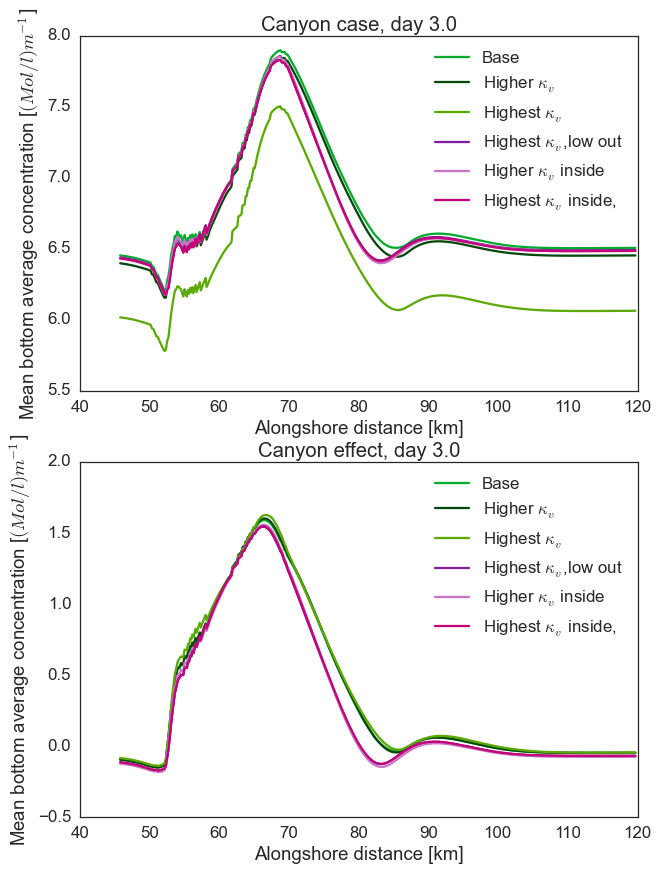

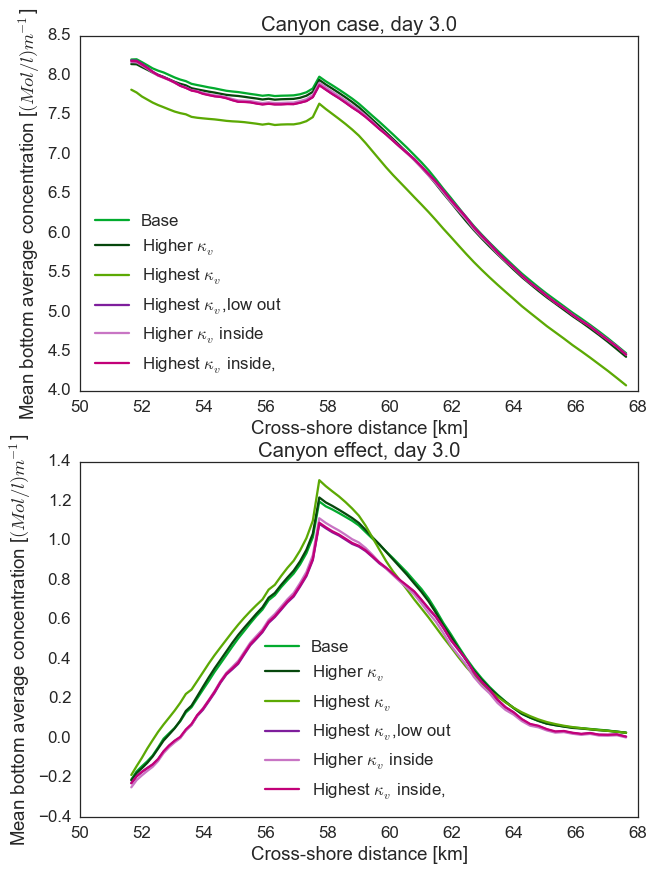

In [27]:
colors = [sns.xkcd_rgb['kelly green'],
          sns.xkcd_rgb['forest green'],
          sns.xkcd_rgb['leaf green'],
          sns.xkcd_rgb['purple'],
          sns.xkcd_rgb['orchid'],
          sns.xkcd_rgb['magenta']]
tt = 6

expsCanyon = [Ptracer,Ptracer11,Ptracer12,Ptracer3D04,Ptracer3D07,Ptracer3D06]
expsFlat = [Ptracer07,Ptracer24,Ptracer25,Ptracer30,Ptracer30,Ptracer07]

labels = ['Base',
          'Higher $\kappa_v$',
          'Highest $\kappa_v$',
          'Highest $\kappa_v$,low out',
          'Higher $\kappa_v$ inside',
          'Highest $\kappa_v$ inside,',
          ]

tracers = ['Tr1','Tr2','Tr3','Tr1','Tr1','Tr1','Tr1']
tracersNoC = ['Tr1','Tr1','Tr1','Tr1','Tr1','Tr1','Tr1']


plot_pool_profile_AS(tt,colors,tracers,tracersNoC,labels,expsCanyon,expsFlat)
plot_pool_profile_CS(tt,colors,tracers,tracersNoC,labels,expsCanyon,expsFlat)

(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(<matplotlib.figure.Figure at 0x7f02f1503910>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f02f1483b90>)

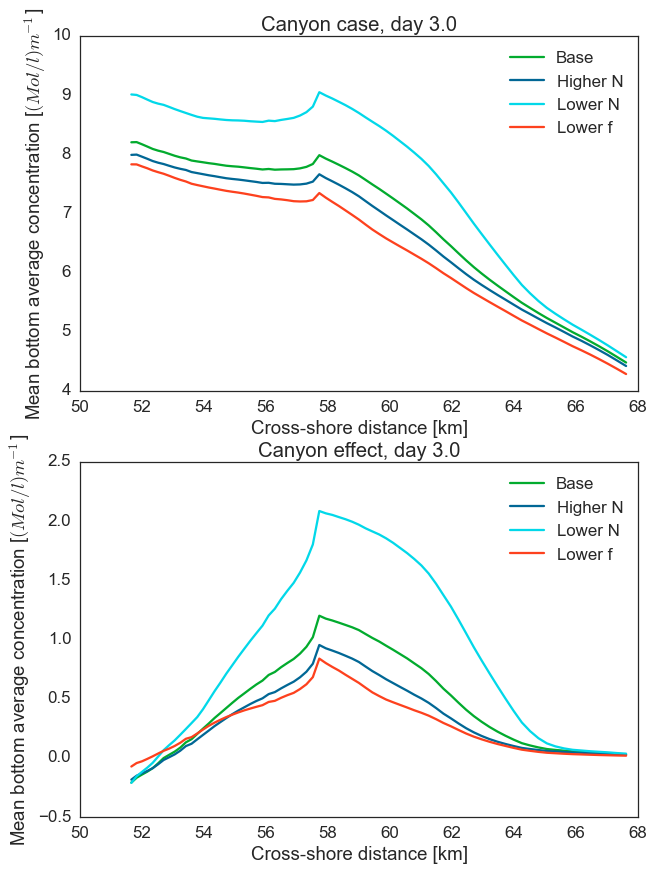

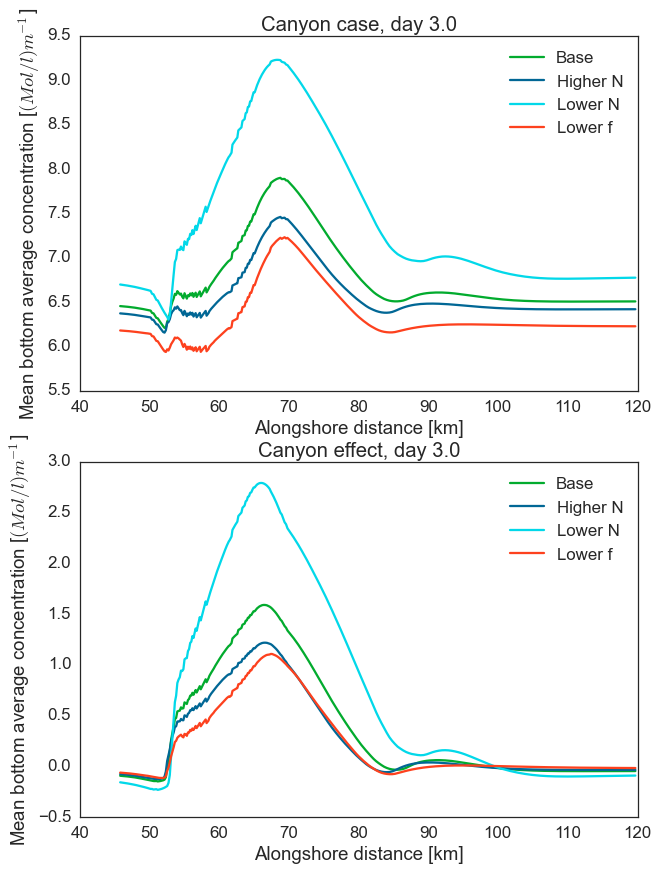

In [19]:
colors = [sns.xkcd_rgb['kelly green'],
          sns.xkcd_rgb['peacock blue'],
          sns.xkcd_rgb['aqua blue'],
          sns.xkcd_rgb['orange red'],
          ]
sns.set_palette(colors)

tt = 6
expsCanyon = [Ptracer,Ptracer15,Ptracer14,Ptracer19]
expsFlat = [Ptracer07,Ptracer27,Ptracer26,Ptracer23]

labels = ['Base',
          'Higher N',
          'Lower N',
          'Lower f']

tracers = ['Tr1','Tr1','Tr1','Tr1']
tracersNoC = ['Tr1','Tr1','Tr1','Tr1']

plot_pool_profile_CS(tt,colors,tracers,tracersNoC,labels,expsCanyon,expsFlat)
plot_pool_profile_AS(tt,colors,tracers,tracersNoC,labels,expsCanyon,expsFlat)

(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(<matplotlib.figure.Figure at 0x7f02f13ed590>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f02f2febd90>)

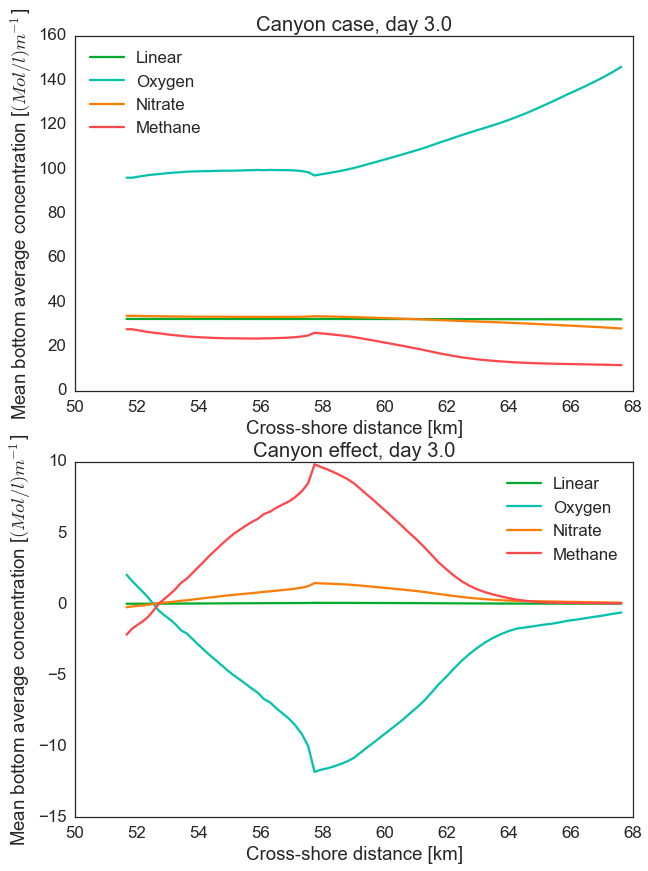

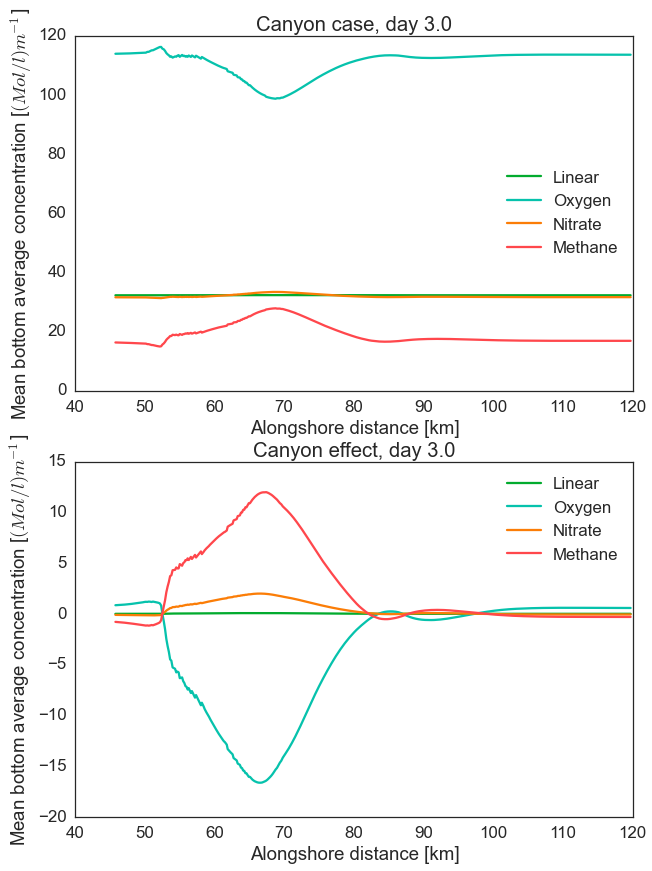

In [22]:
colors = [sns.xkcd_rgb['kelly green'],
          sns.xkcd_rgb['turquoise'],
          sns.xkcd_rgb['pumpkin orange'],
          sns.xkcd_rgb['light red']]
          
sns.set_palette(colors)

expsCanyon = [PtracerBar]
expsFlat = [PtracerBarFlat]

tracers = ['Tr01','Tr03','Tr04','Tr08']
tracersNoC = ['Tr01','Tr03','Tr04','Tr08']

labels = ['Linear-Base','Oxygen','Nitrate','Methane']

tt = 6

plot_pool_profile_CS_BAR(tt,colors,tracers,tracersNoC,labels)
plot_pool_profile_AS_BAR(tt,colors,tracers,tracersNoC,labels)

## Advective Phase

(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(<matplotlib.figure.Figure at 0x7f02f32aea50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f02f65d3cd0>)

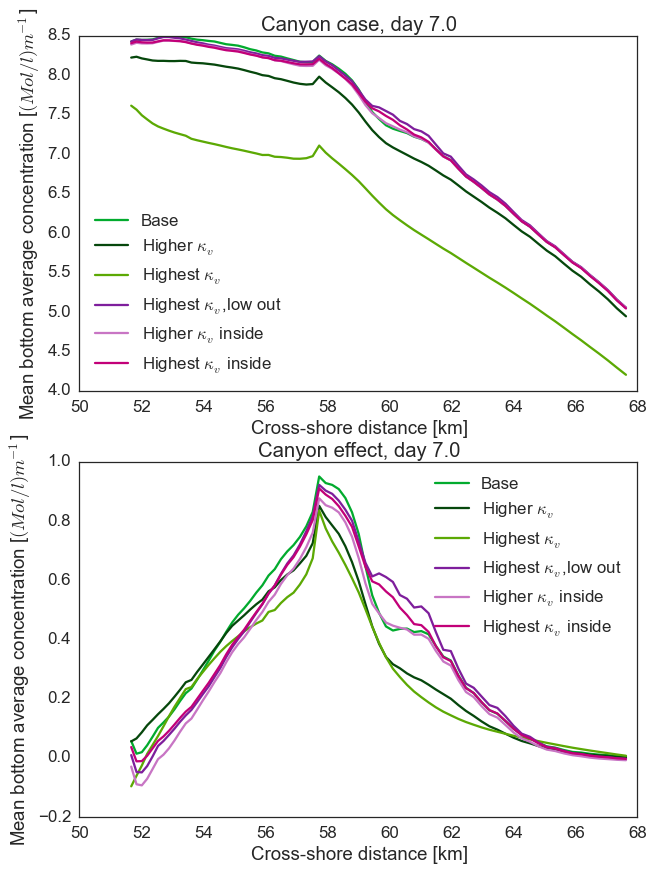

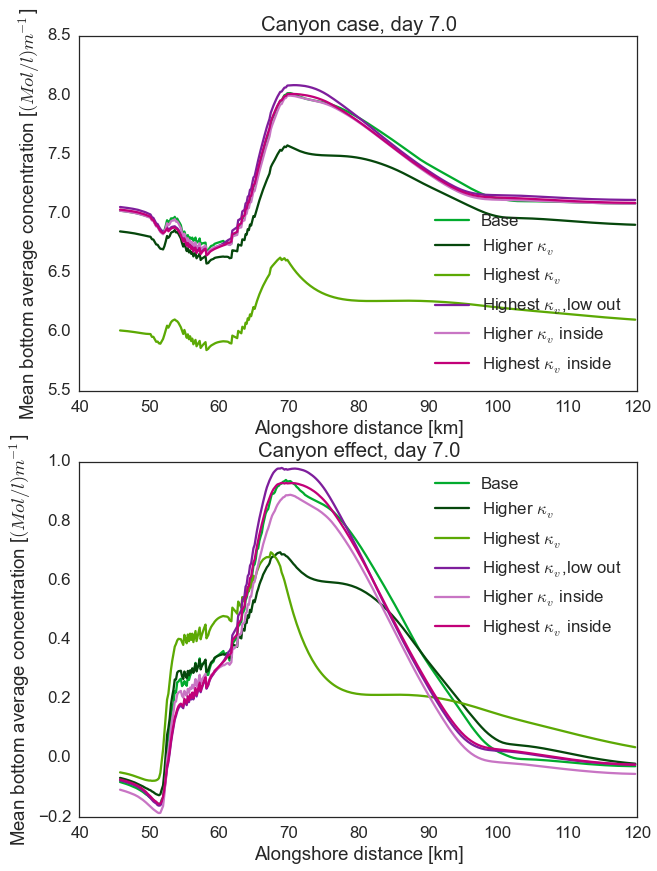

In [28]:
colors = [sns.xkcd_rgb['kelly green'],
          sns.xkcd_rgb['forest green'],
          sns.xkcd_rgb['leaf green'],
          sns.xkcd_rgb['purple'],
          sns.xkcd_rgb['orchid'],
          sns.xkcd_rgb['magenta']]
tt = 14

expsCanyon = [Ptracer,Ptracer11,Ptracer12,Ptracer3D04,Ptracer3D07,Ptracer3D06]
expsFlat = [Ptracer07,Ptracer24,Ptracer25,Ptracer30,Ptracer30,Ptracer07]

labels = ['Base',
          'Higher $\kappa_v$',
          'Highest $\kappa_v$',
          'Highest $\kappa_v$,low out',
          'Higher $\kappa_v$ inside',
          'Highest $\kappa_v$ inside',
          ]

tracers = ['Tr1','Tr2','Tr3','Tr1','Tr1','Tr1','Tr1']
tracersNoC = ['Tr1','Tr1','Tr1','Tr1','Tr1','Tr1','Tr1']


plot_pool_profile_CS(tt,colors,tracers,tracersNoC,labels,expsCanyon,expsFlat)
plot_pool_profile_AS(tt,colors,tracers,tracersNoC,labels,expsCanyon,expsFlat)

(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(<matplotlib.figure.Figure at 0x7f02f3067d90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f02f1715a50>)

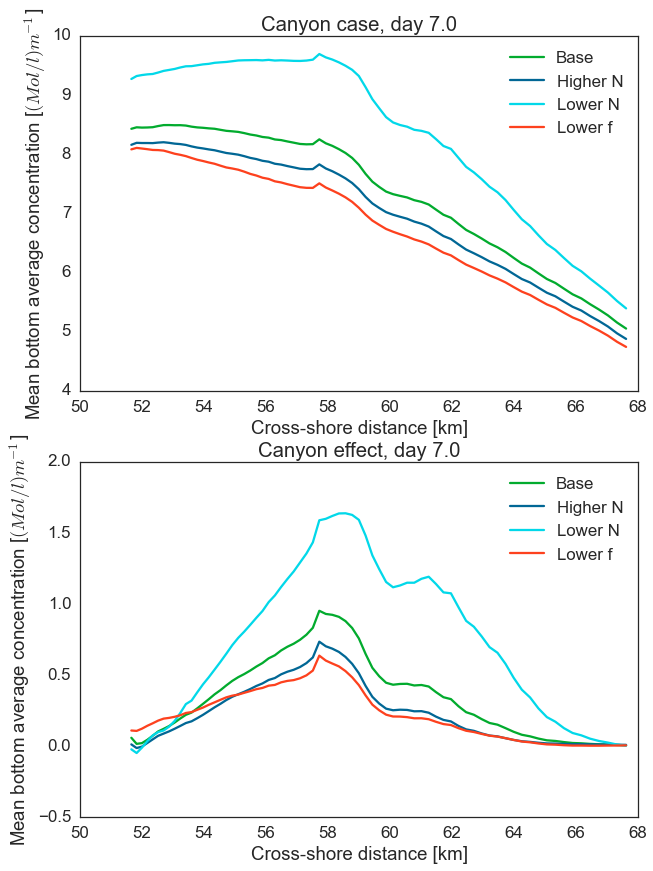

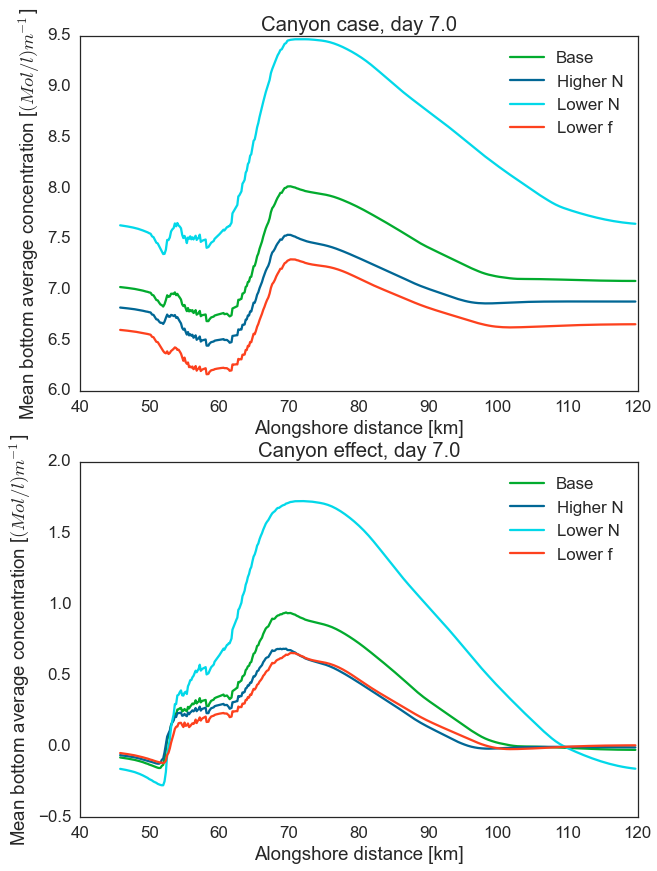

In [24]:
colors = [sns.xkcd_rgb['kelly green'],
          sns.xkcd_rgb['peacock blue'],
          sns.xkcd_rgb['aqua blue'],
          sns.xkcd_rgb['orange red'],
          ]
sns.set_palette(colors)

tt = 14
expsCanyon = [Ptracer,Ptracer15,Ptracer14,Ptracer19]
expsFlat = [Ptracer07,Ptracer27,Ptracer26,Ptracer23]

labels = ['Base',
          'Higher N',
          'Lower N',
          'Lower f']

tracers = ['Tr1','Tr1','Tr1','Tr1']
tracersNoC = ['Tr1','Tr1','Tr1','Tr1']

plot_pool_profile_CS(tt,colors,tracers,tracersNoC,labels,expsCanyon,expsFlat)
plot_pool_profile_AS(tt,colors,tracers,tracersNoC,labels,expsCanyon,expsFlat)

(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(<matplotlib.figure.Figure at 0x7f02f6ac3750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f02f68b01d0>)

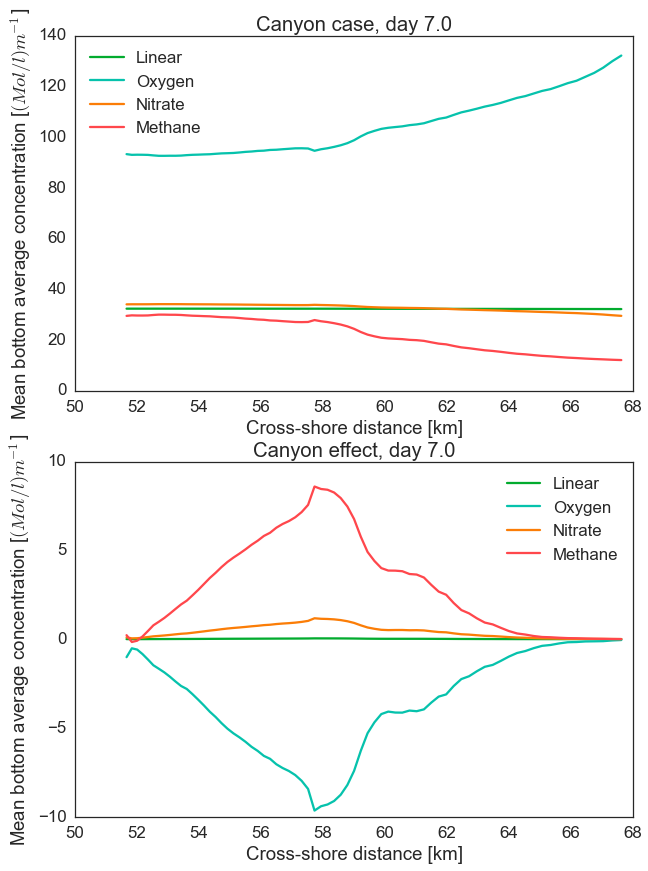

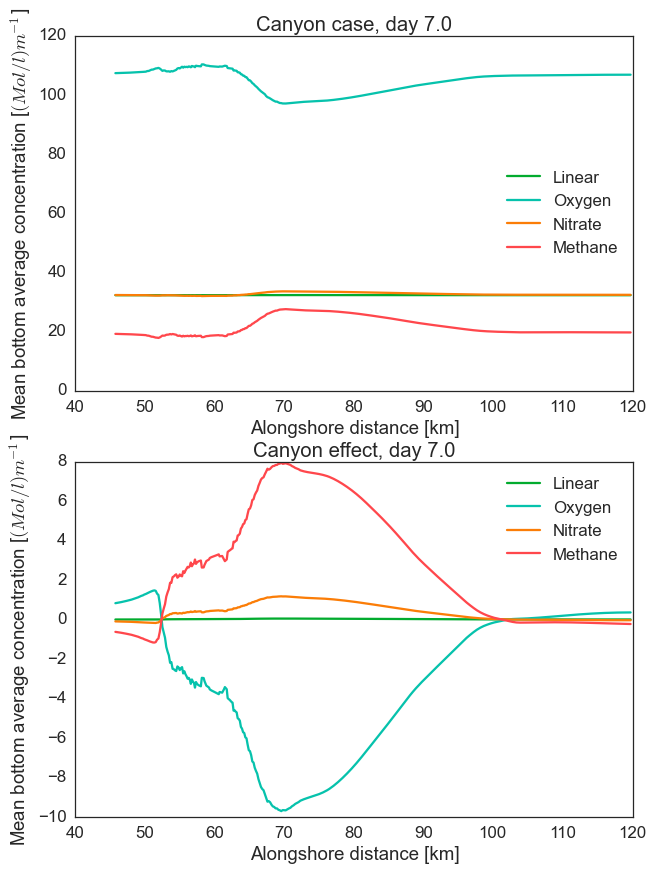

In [26]:
colors = [sns.xkcd_rgb['kelly green'],
          sns.xkcd_rgb['turquoise'],
          sns.xkcd_rgb['pumpkin orange'],
          sns.xkcd_rgb['light red']]
          
sns.set_palette(colors)

expsCanyon = [PtracerBar]
expsFlat = [PtracerBarFlat]

tracers = ['Tr01','Tr03','Tr04','Tr08']
tracersNoC = ['Tr01','Tr03','Tr04','Tr08']

labels = ['Linear','Oxygen','Nitrate','Methane']

tt = 14

plot_pool_profile_CS_BAR(tt,colors,tracers,tracersNoC,labels)
plot_pool_profile_AS_BAR(tt,colors,tracers,tracersNoC,labels)